<a href="https://colab.research.google.com/github/Ayush310803/ViT/blob/main/HRNet_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install timm torch torchvision kaggle

In [15]:
import os
import zipfile
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [16]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"
!kaggle datasets download -d rajkumarl/people-clothing-segmentation

Dataset URL: https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation
License(s): CC0-1.0
people-clothing-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [17]:
dataset_zip = "/content/people-clothing-segmentation.zip"
extract_path = "/content/dataset"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully.")
!ls /content/dataset

✅ Dataset extracted successfully.
 jpeg_images   jpeg_masks  'labels (1).csv'   labels.csv   png_images   png_masks


In [18]:
image_dir = "/content/dataset/jpeg_images/IMAGES"
mask_dir = "/content/dataset/jpeg_masks/MASKS"
label_path = "/content/dataset/labels.csv"

In [19]:
df = pd.read_csv(label_path)
print("✅ Labels Loaded")
print(df.head())

✅ Labels Loaded
   Unnamed: 0   label_list
0           0          NaN
1           1  accessories
2           2          bag
3           3         belt
4           4       blazer


In [20]:
class PeopleClothingDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

In [21]:
image_filenames = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg'))])  # check for both .jpg and .jpeg
mask_filenames = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.lower().endswith(('.jpg', '.jpeg'))])  # check for both .jpg and .jpeg

print(f"Number of image files found: {len(image_filenames)}")
print(f"Number of mask files found: {len(mask_filenames)}")

train_images, val_images, train_masks, val_masks = train_test_split(image_filenames, mask_filenames, test_size=0.2, random_state=42)

Number of image files found: 1000
Number of mask files found: 1000


In [22]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [23]:
train_dataset = PeopleClothingDataset(train_images, train_masks, transform=transform)
val_dataset = PeopleClothingDataset(val_images, val_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [24]:
import timm
model = timm.create_model('hrnet_w18', pretrained=True)

features = model.forward_features(torch.randn(1, 3, 224, 224))
num_channels_last_layer = features.shape[1]

model.global_pool = nn.Identity()
model.classifier = nn.Identity()

segmentation_head = nn.Sequential(
    nn.ConvTranspose2d(num_channels_last_layer, 256, kernel_size=2, stride=2),
    nn.Conv2d(256, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
    nn.Conv2d(64, 32, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 1, kernel_size=1),
    nn.Sigmoid()
)

model = nn.Sequential(model, segmentation_head)

model.to("cuda" if torch.cuda.is_available() else "cpu")

Sequential(
  (0): HighResolutionNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identit

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        masks = transforms.Resize(outputs.shape[2:])(masks)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss / len(train_loader):.4f}")

print("🎉 Training Complete!")

Epoch 1/5, Loss: 0.7004
Epoch 2/5, Loss: 0.6931
Epoch 3/5, Loss: 0.6931
Epoch 4/5, Loss: 0.6931
Epoch 5/5, Loss: 0.6931
🎉 Training Complete!


In [27]:
from google.colab import drive
drive.mount('/content/drive')

model_save_path = '/content/drive/MyDrive/trained_model.pth'
torch.save(model.state_dict(), model_save_path)

print(f"🎉 Model saved to {model_save_path}")

Mounted at /content/drive
🎉 Model saved to /content/drive/MyDrive/trained_model.pth


<ipython-input-38-544f23236504>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


✅ Model Loaded Successfully!
torch.Size([1, 1, 28, 28])
tensor(5.5643e-33, grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>) tensor(7.1605e-36, grad_fn=<MeanBackward0>)


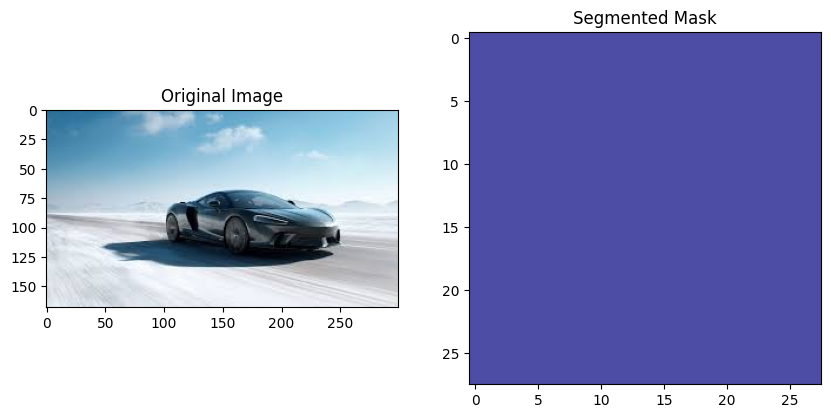

In [38]:
import torch
import timm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.nn as nn

MODEL_PATH = "/content/drive/MyDrive/trained_model.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('hrnet_w18', pretrained=True)

features = model.forward_features(torch.randn(1, 3, 224, 224))
num_channels_last_layer = features.shape[1]
model.global_pool = nn.Identity()
model.classifier = nn.Identity()

segmentation_head = nn.Sequential(
    nn.ConvTranspose2d(num_channels_last_layer, 256, kernel_size=2, stride=2),
    nn.Conv2d(256, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
    nn.Conv2d(64, 32, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 1, kernel_size=1),
    nn.Sigmoid()
)

model = nn.Sequential(model, segmentation_head)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

print("✅ Model Loaded Successfully!")

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)

def segment_image(image_path):
    image_tensor = preprocess_image(image_path)
    output = model(image_tensor)
    print(output.shape)
    print(output.max(), output.min(), output.mean())

    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)
        output = output.squeeze().cpu().numpy()

    return output

def visualize_segmentation(image_path):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    segmented_mask = segment_image(image_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")

    axes[1].imshow(segmented_mask, cmap="jet", alpha=0.7)
    axes[1].set_title("Segmented Mask")

    plt.show()

visualize_segmentation("/content/download (1).jpeg")
